In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif, RFE

In [2]:
feats = pd.read_csv("../System/feats_train.csv")

af = feats.loc[feats['class'] == 1]
naf = feats.loc[feats['class'] == 0]

feats.set_index('index', inplace=True)

labels = feats["class"]
feats.drop('class', axis=1, inplace=True)

t10_table = pd.DataFrame()

K_FEATS = 5

In [3]:
fake = pd.read_csv("../System/fake_news_feats_train.csv")
fake_labels = fake["class"]
fake.drop('class', axis=1, inplace=True)

In [4]:
groups = ["complexity", "deception", "details", "formality"
                  ,"humour", "imagination", "vagueness"]

colour_map = {"complexity":"C0", "deception":"C1", "details":"C2", "formality":"C3"
                  ,"humour":"C4", "imagination":"C5", "vagueness":"C6"}

feat_group_map = dict()

for g in groups:
    with open("../System/feature_sets/{}.txt".format(g)) as file:
        for line in file:
            if line.strip() in feats.columns:
                feat_group_map[line.strip()] = g

In [5]:
def classify(tab, lab):
    classifier = LogisticRegression()

    pipeline = Pipeline([
            #('normalizer', StandardScaler()),  # Step1 - normalize data
    #         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
            ('clf', classifier)  # Step2 - classifier
            ])

    predicted = cross_val_predict(pipeline, tab, lab, cv=10)

    score = metrics.f1_score(lab, predicted, pos_label=1)
    precision = metrics.average_precision_score(lab, predicted)
    recall = metrics.recall_score(lab, predicted)
    accuracy = metrics.accuracy_score(lab, predicted)

    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Accuracy: {}".format(accuracy))
    print("F1-Score: {}".format(score))

In [6]:
def univariate_selection(method, tab, lab, k=10):
    best = SelectKBest(method, k)
    best.fit_transform(tab, lab)
    t10 = tab.loc[:, best.get_support()]
    return t10

In [7]:
def sort_top_10(top_10):
    df = pd.DataFrame()
    df['Feature'] = top_10
    df['Group'] = df['Feature'].map(feat_group_map)
    df = df.sort_values(by='Group')
    return list(df['Feature'].values)

In [8]:
t10_chi = univariate_selection(chi2, feats, labels, k=K_FEATS)
top_10 = sort_top_10(t10_chi.columns)
t10_table['Chi'] = top_10
print(top_10)
print('\n')
classify(t10_chi, labels)

['lexical_diversity', 'fp_pronouns', 'ap_num', 'ap_date', 'degree_adverbs']


Precision: 0.6058864703757225
Recall: 0.653179190751445
Accuracy: 0.6599229287090559
F1-Score: 0.6576139670223083


In [9]:
t10_f = univariate_selection(f_classif, feats, labels, k=K_FEATS)
top_10 = sort_top_10(t10_f.columns)
t10_table['F'] = top_10
print(top_10)
print('\n')
classify(t10_f, labels)

['lexical_diversity', 'fp_pronouns', 'time_related', 'sense_words', 'preposition']


Precision: 0.6183127923901601
Recall: 0.6628131021194605
Accuracy: 0.674373795761079
F1-Score: 0.6705653021442495


In [10]:
t10_info = univariate_selection(mutual_info_classif, feats, labels, k=K_FEATS)
top_10 = sort_top_10(t10_info.columns)
t10_table['Mutual Information'] = top_10
print(top_10)
print('\n')
classify(t10_info, labels)

['body_punctuation', 'lexical_diversity', 'fp_pronouns', 'ima_conjunctions', 'adjectives']


Precision: 0.6147924844179495
Recall: 0.6628131021194605
Accuracy: 0.6705202312138728
F1-Score: 0.6679611650485436


In [11]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=K_FEATS, step=1)
rfe.fit(feats, labels)
chosen = rfe.ranking_ == 1
t10_rfe = feats.loc[:, chosen]
top_10 = sort_top_10(t10_rfe.columns)
t10_table['RFE'] = top_10
print(top_10)
print('\n')
classify(t10_rfe, labels)

['readability', 'lexical_diversity', 'proper_nouns', 'time_related', 'degree_adverbs']


Precision: 0.6105763103244042
Recall: 0.6608863198458574
Accuracy: 0.6657032755298651
F1-Score: 0.6640851887705712


In [12]:
CLF = LogisticRegression()

pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
#         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
        ('clf', CLF)  # Step2 - classifier
        ])

pipeline.fit(feats, labels)

coeffs = CLF.coef_.ravel()

rank_pd = pd.DataFrame()
rank_pd['Weights'] = coeffs
rank_pd['Features'] = feats.columns.values
rank_pd['Weights'] = rank_pd['Weights'].abs()
sorted_ranks = rank_pd.sort_values(by='Weights', ascending=False)
chosen_columns = sorted_ranks.head(K_FEATS)['Features']
t10_weights = feats.loc[:, chosen_columns]
top_10 = sort_top_10(t10_weights.columns)
t10_table['Weights'] = top_10

print(top_10)
print('\n')
classify(t10_weights, labels)

['lexical_diversity', 'avg_sentence_len', 'readability', 'time_related', 'preposition']


Precision: 0.6063275678364722
Recall: 0.6608863198458574
Accuracy: 0.6608863198458574
F1-Score: 0.6608863198458574


In [13]:
t10_table

,Chi,F,Mutual Information,RFE,Weights
0,lexical_diversity,lexical_diversity,body_punctuation,readability,lexical_diversity
1,fp_pronouns,fp_pronouns,lexical_diversity,lexical_diversity,avg_sentence_len
2,ap_num,time_related,fp_pronouns,proper_nouns,readability
3,ap_date,sense_words,ima_conjunctions,time_related,time_related
4,degree_adverbs,preposition,adjectives,degree_adverbs,preposition


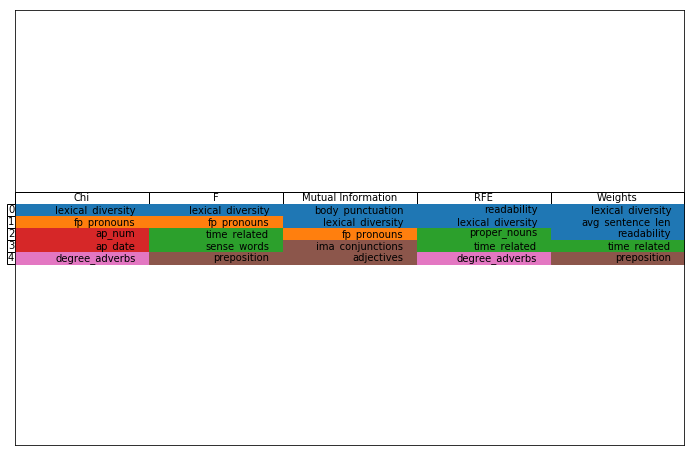

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

the_table=plt.table(cellText=t10_table.values, rowLabels=t10_table.index, colLabels=t10_table.columns, 
                    loc='center')



table_props = the_table.properties()
table_cells = table_props['child_artists']

for cell in table_cells:
    txt = cell.get_text().get_text()
    if txt in feat_group_map:
        group = feat_group_map[txt]
        colour = colour_map[group]
        cell.set_color(colour)
        
fig.savefig("top_5_table.pdf", bbox_inches='tight')

In [15]:
top_names = list(set(t10_table.values.ravel()))
pd_top_names = pd.DataFrame()
pd_top_names['Feats'] = sort_top_10(top_names)
pd_top_names['Group'] = pd_top_names['Feats'].map(feat_group_map)

top_feats = feats.loc[:, top_names]
classify(top_feats, labels)

print(pd_top_names.to_latex())

with open("../System/feature_sets/fs_t{}".format(K_FEATS), 'w') as file:
    for f in pd_top_names['Feats']:
        file.write("{}\n".format(f))

Precision: 0.6292771900964914
Recall: 0.674373795761079
Accuracy: 0.6868978805394991
F1-Score: 0.6829268292682927
\begin{tabular}{lll}
\toprule
{} &              Feats &        Group \\
\midrule
0  &   body\_punctuation &   complexity \\
1  &   avg\_sentence\_len &   complexity \\
2  &  lexical\_diversity &   complexity \\
3  &        readability &   complexity \\
4  &        fp\_pronouns &    deception \\
5  &       time\_related &      details \\
6  &        sense\_words &      details \\
7  &       proper\_nouns &      details \\
8  &            ap\_date &    formality \\
9  &             ap\_num &    formality \\
10 &        preposition &  imagination \\
11 &         adjectives &  imagination \\
12 &   ima\_conjunctions &  imagination \\
13 &     degree\_adverbs &    vagueness \\
\bottomrule
\end{tabular}



In [16]:
pd_top = pd.DataFrame()
pd_top['Feats'] = t10_table.values.ravel()
top_counts = pd_top.groupby(pd_top.Feats).size()
top_counts = pd.DataFrame(top_counts)
top_counts = top_counts.loc[top_counts[0] > 1]

top_feats = feats.loc[:, top_counts.index.values]
print("{}\n".format(top_feats.shape))
classify(top_feats, labels)

(1038, 6)

Precision: 0.6227846680509568
Recall: 0.6763005780346821
Accuracy: 0.6801541425818882
F1-Score: 0.6789168278529981


In [17]:
o2_names = top_counts.index.values
pd_o2_names = pd.DataFrame()
pd_o2_names['Feats'] = sort_top_10(o2_names)
pd_o2_names['Group'] = pd_o2_names['Feats'].map(feat_group_map)

pd_o2_names

,Feats,Group
0,lexical_diversity,complexity
1,readability,complexity
2,fp_pronouns,deception
3,time_related,details
4,preposition,imagination
5,degree_adverbs,vagueness


In [18]:
pd_top_names = pd.DataFrame()
pd_top_names['Feats'] = sort_top_10(top_counts.index.values)
pd_top_names['Group'] = pd_top_names['Feats'].map(feat_group_map)

pd_top_names.groupby(by='Group').size()

Group
complexity     2
deception      1
details        1
imagination    1
vagueness      1
dtype: int64

In [19]:
top_fake = fake.loc[:, top_counts.index.values]
classify(top_fake, fake_labels)

Precision: 0.6277403579236044
Recall: 0.6504065040650406
Accuracy: 0.6932270916334662
F1-Score: 0.6751054852320675
